In [1]:
__author__ = 'Robert Nikutta, Stéphanie Juneau, Knut Olsen & the NOAO Data Lab team <datalab@noao.edu>'
__version__ = '201705022' # yyymmdd

# (Re)Discovering the Hydra II dwarf galaxy

*Robert Nikutta, Stéphanie Juneau, Knut Olsen & the NOAO Data Lab team*

# Detecting the Hydra II dwarf galaxy

* [query the SMASH catalog in one field & filter for blue stars (expected in metal-poor dwarfs)](#query)
* [spatial density plot](#spatial)
* [detect overdensities (differential Gaussian kernels)](#kernel)
* [find peaks](#peaks)
* [visually inspect images (Simple Image Access)](#sia)
* [save your results to a local file](#savefile)
* [CM diagrams of all stars around the peaks](#cmdiagrams)

# Data retrieval
We will retrieve data from Field 169 of the SMASH catalog ([Nidever et al. (subm.)](http://adsabs.harvard.edu/abs/2017arXiv170100502N)) and look for overdensities of blue objects.

The required columns are RA, Dec, and the g, r, i magnitudes.

# Detection
We will convolve the spatial distribution of our dataset with a pair of Gaussian kernels and subtract the results, as done by e.g. [Stanford et al. (2005, ApJ, 634, 2, L129)](http://adsabs.harvard.edu/abs/2005ApJ...634L.129S) (galaxy clusters), or [Koposov et al. (2008, ApJ, 686, 279)](http://adsabs.harvard.edu/abs/2008ApJ...686..279K) (MW satellites). This has the effect of convolving the spatial distribution with a Mexican hat filter, which is useful for detecting objects at a desired spatial scale.

# Imports & initialization

In [2]:
# std lib
import sys
import warnings
warnings.filterwarnings('ignore')  # I know, I know...

# 3rd party
import numpy as np
from astropy import utils, io, convolution, stats
from photutils import find_peaks
import pylab as plt
import matplotlib
%matplotlib inline
from IPython.display import FileLink

# Data Lab
from dl import helpers

# plots default setup
fontsize = 14
plt.rcParams['font.size'] =  fontsize
plt.rcParams['figure.figsize'] = (7, 5.8)

# Make a query helper
Use helper class `Querist` from the helpers module. It simply hides a lot of boilerplate that we don't want to worry about right now.

In [3]:
Q = helpers.Querist('anonymous')  # username, here 'anonymous'

Authentication successful.


We will use the `Querist` instance to get some tables into RAM. Let's see what output formats are currently supported:

In [4]:
Q.output_formats

'outfmt' arg   Returned output
------------------------------
      string   CSV formatted table as a string
       array   Numpy array
 structarray   Numpy structured / record array
      pandas   Pandas dataframe
       table   Astropy Table
     votable   Astropy VOtable


<a class="anchor" id="query"></a>
# Query the SMASH DR1 database

We will query the averaged photometry table from the SMASH catalog and select field #169.  We will limit the query to avoid photometry taken only with short exposures (depthflag>1), avoid broad objects (|sharp|<0.5), and pick blue objects (-0.4 < g-r < 0.4).
## Construct the query string

In [5]:
field = 169 # SMASH field number to query
depth = 1   # depth (=no short exposures please)

# Create the query string; SQL keyword capitalized for clarity
query_template =\
"""SELECT ra,dec,gmag,rmag,imag
   FROM smash_dr1.object
   WHERE fieldid = '%d' AND
         depthflag > %d AND
         ndetr > 3 AND ndetg > 3 AND
         abs(sharp) < 0.5 AND
         gmag BETWEEN 9 AND 25 AND
         (gmag-rmag) BETWEEN -0.4 AND 0.4"""

query = query_template % (field, depth)

# Submit the query
Running the query in synchroneous mode is very easy with the `Querist` helper.

In [6]:
%%time
# get result as a Pandas dataframe; and let's preview the first two rows
R = Q(query,outfmt='pandas')
print "Number of objects found:", R.shape[0]
R.head() # a Pandas method

Returning Pandas dataframe
Number of objects found: 107358
CPU times: user 0 ns, sys: 635 ms, total: 635 ms
Wall time: 12 s


<a class="anchor" id="spatial"></a>
# Make a figure of the spatial distribution

You might spot some overdensities already.

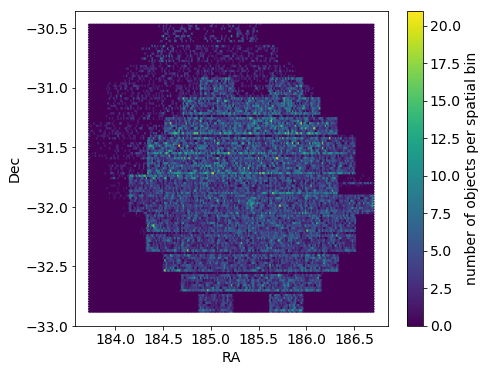

In [7]:
plt.hexbin(R['ra'], R['dec'],gridsize=200)
plt.xlabel('RA'); plt.ylabel('Dec')
plt.colorbar(label='number of objects per spatial bin');

<a class="anchor" id="kernel"></a>
# The Dwarf Filter
Here we define the dwarf filter as a differential convolution of a two-dimensional image using two Gaussian kernels; this has the effect of convolution with a Mexican hat filter.  The default kernel shapes look for objects on the scale of a few arcmin.  The output includes a clipped array of the convolved spatial distribution, which we will use for peak detection.

In [8]:
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick. Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print "Computing differential convolution .... ",
    sys.stdout.flush()

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max())/2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    print nx,ny
    
    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta)                       # not used
    floor = mean 

    print 'dwarf_filter: mean = %g  sigma = %g sigmaRaw = %g' % (mean, sigma, sigmaRaw)

    # Clip to specified limits.
    clipped = delta.copy()
    clipped[ delta < floor ] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

# Run the dwarf filter
We'll use the default convolution kernels of 2 and 20 arcminutes in size.

In [9]:
%%time
small_k, big_k = 2., 20.  # arcminutes
raw, extent, delta, clipped, dsigma = dwarf_filter(R['ra'],R['dec'],fwhm_small=small_k,fwhm_big=big_k)

Computing differential convolution ....  152 144
dwarf_filter: mean = 0.0958756  sigma = 1.78298 sigmaRaw = 5.32749
CPU times: user 455 ms, sys: 16 ms, total: 471 ms
Wall time: 468 ms


# Plot the convolved 2D histogram

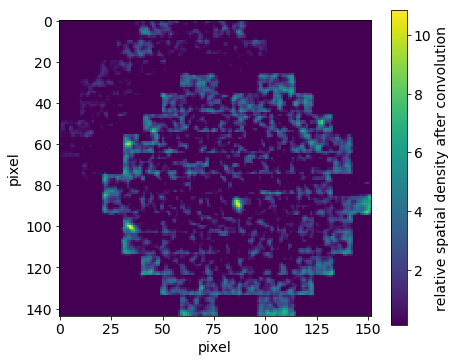

In [10]:
fig, ax = plt.subplots()
im = plt.imshow(clipped)
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution');

**Some peaks are visible, let's locate them automatically...**

<a class="anchor" id="peaks"></a>
# Identify peaks
We'll use the `photutils` package to identify 10-sigma peaks in the clipped filtered image.

In [11]:
# find peaks
mean, median, std = stats.sigma_clipped_stats(clipped,sigma=3.0,iters=5)    
tbl = find_peaks(clipped,median+10,box_size=small_k*2)

# add ra & dec positions of peaks found
a, b = extent[:2]
xvec = np.arange(a,b,(b-a)/clipped.shape[1])
a, b = extent[2:]
yvec = np.arange(a,b,(b-a)/clipped.shape[0])

tbl['ra'] = xvec[tbl['x_peak']]
tbl['dec'] = yvec[-tbl['y_peak']-1]
print tbl

x_peak y_peak   peak_value        ra           dec      
------ ------ ------------- ------------- --------------
    86     89 10.4554540657 185.410559533 -31.9761200869
    34    100 10.8515422106 184.393480413  -32.159634683


# Show the identified density peaks

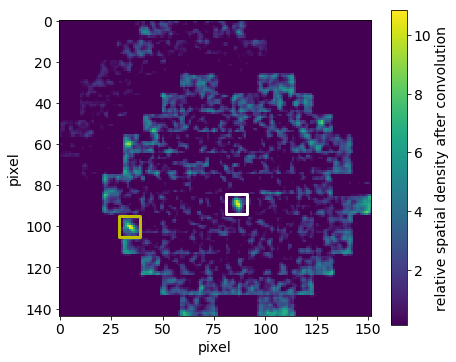

In [12]:
ecs = ['w','y'] # colors of box frames
ax.scatter(tbl['x_peak'],tbl['y_peak'],marker='s',s=tbl['peak_value']*40,c='none',edgecolors=ecs,lw=3) # keeps writing to previous ax
fig  # repeats (the updated) figure

<a class="anchor" id="sia"></a>
# Inspect the image cutouts around the peaks
# *Simple Image Access service*
Data Lab comes with batteries included. Image cutout and download services are built in.

In [13]:
# set up SIA
from pyvo.dal import sia
DEF_ACCESS_URL = "http://zeus1.datalab.noao.edu/siapv1"
svc = sia.SIAService(DEF_ACCESS_URL)

# a little func to download the deepest stacked images
def download_deepest_images(ra,dec,fov=0.1,bands=list('gri')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print "The full image list contains", len(imgTable), "entries"
    sel0 = (imgTable['proctype']=='Stacked') & (imgTable['prodtype']=='image') # basic selection
    images = []
    for band in bands:
        print "Band %s:" % band,
        sel = sel0 & (imgTable['obs_bandpass']==band) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print 'downloading deepest stacked image...'
        img = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))
        images.append(img)
        
    print "Downloaded %d images." % len(images)
    return images

# multi panel image plotter
def plot_images(images,geo=None,panelsize=3.5,bands=list('gri'),cmap=matplotlib.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=matplotlib.colors.PowerNorm(0.2,vmin=1.01*img.min(),vmax=0.3*img.max()))
        ax.set_title('%s band' % bands[j])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# Get images for the "left yellow" box

The full image list contains 2604 entries
Band g: downloading deepest stacked image...
Band r: downloading deepest stacked image...
Band i: downloading deepest stacked image...
Downloaded 3 images.
CPU times: user 1.39 s, sys: 69 ms, total: 1.46 s
Wall time: 2.51 s


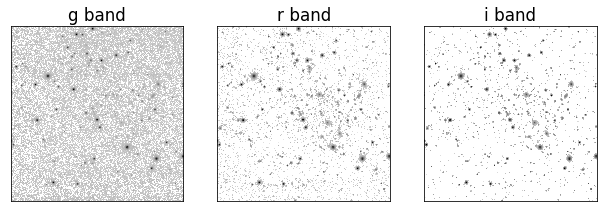

In [14]:
%%time
bands = list('gri')
images = download_deepest_images(tbl['ra'][1], tbl['dec'][1], fov=0.1, bands=bands) # FOV in deg
plot_images(images,bands=bands)

**Looks like a galaxy cluster!**

# Now the "white center box" object

The full image list contains 2713 entries
Band g: downloading deepest stacked image...
Band r: downloading deepest stacked image...
Band i: downloading deepest stacked image...
Downloaded 3 images.


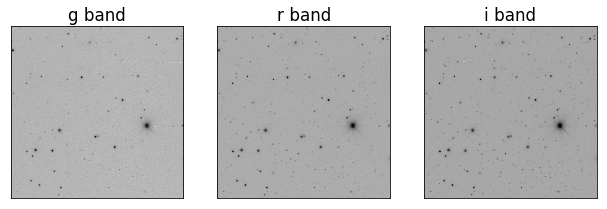

In [15]:
images = download_deepest_images(tbl['ra'][0], tbl['dec'][0],fov=0.1,bands=bands)
plot_images(images)

**Definitley not a galaxy cluster, just a stellar overdensity**

<a class="anchor" id="cmdiagrams"></a>
# Query the database for stars near peaks
Get photometry of stars within a 5 arcmin radius of each density peak.

In [16]:
def makequery(ra0,dec0,radius0=5./60.,field=169,depth=1):
    query =\
    """SELECT ra,dec,gmag,rmag,imag FROM smash_dr1.object
       WHERE fieldid = '%d' AND
           depthflag > %d AND
           abs(sharp) < 0.5 AND
           gmag BETWEEN 9 AND 25 AND
           q3c_radial_query(ra,dec,%s,%s,%s)
    """ % (field, depth,ra0,dec0,radius0)
    
    return query

In [17]:
query1 = makequery(tbl['ra'][0],tbl['dec'][0]) # center ra & dec
R1 = Q(query1,outfmt='pandas')
print len(R1), "objects found."

Returning Pandas dataframe
2075 objects found.


# Compute color

In [18]:
R1['g_r'] = R1['gmag'] - R1['rmag']
R1.tail()  # another Pandas method

,ra,dec,gmag,rmag,imag,g_r
2070,185.481100,-31.920878,23.4500,22.6088,22.2495,0.8412
2071,185.472299,-31.916688,24.4480,24.6672,24.7170,-0.2192
2072,185.474164,-31.913135,24.5896,23.5522,23.0045,1.0374
2073,185.467208,-31.913037,21.1127,20.5677,20.3318,0.5450
2074,185.472472,-31.911803,21.2613,20.8693,20.7097,0.3920


# Now the other peak

In [19]:
query2 = makequery(tbl['ra'][1],tbl['dec'][1])
R2 = Q(query2,outfmt='pandas')
print len(R2), "objects found."

# compute color
R2['g_r'] = R2['gmag'] - R2['rmag']
R2.tail()

Returning Pandas dataframe
1950 objects found.


,ra,dec,gmag,rmag,imag,g_r
1945,184.471635,-32.119314,24.8892,24.7936,24.4675,0.0956
1946,184.481076,-32.122957,22.7491,21.3313,20.3926,1.4178
1947,184.470299,-32.112379,23.6478,22.0852,21.7193,1.5626
1948,184.470477,-32.112378,23.9190,22.3518,21.6330,1.5672
1949,184.467250,-32.106465,24.0911,23.3406,22.9431,0.7505


# Color-magnitude diagrams of the peaks

In [20]:
def plotpanel(axid,x,y,title='',xlim=(-1,2),ylim=(25.2,14)):
    ax = fig.add_subplot(axid)
    ax.scatter(x,y,marker='.',s=10, alpha=0.8)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)

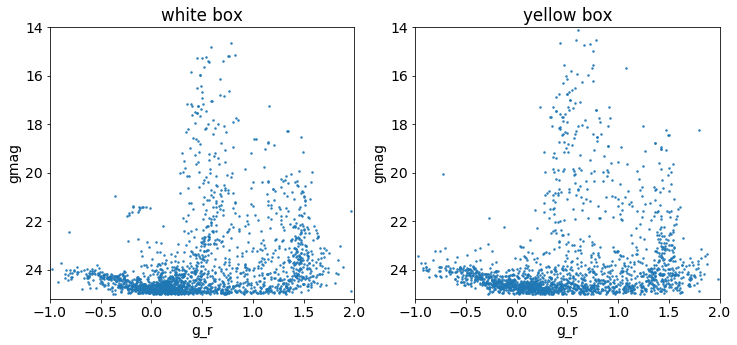

In [21]:
fig = plt.figure(figsize=(12,5))
plotpanel(121,R1['g_r'],R1['gmag'],'white box')
plotpanel(122,R2['g_r'],R2['gmag'],'yellow box')

# Compare w/ Vivas+2016
![title](Vivas2016fig9.png)

<a class="anchor" id="savefile"></a>
# Save your results to a local file, take it with you
Let's save the photometry of all sources around the location of the dwarf galaxy (i.e. the objects we used to create the CMD) to a local file. Take it with you if you like.

In [22]:
# save the photometry of Field 1 to a CSV local file
R1.to_csv('hydra_II_photometry.csv',index=False) # save to local file

# print the first few lines of that file (using ! as a system call from this notebook)
!head -5 hydra_II_photometry.csv

# make a nice download link here
print "\nClick to download:"
FileLink('hydra_II_photometry.csv')

ra,dec,gmag,rmag,imag,g_r
185.341390444,-32.0346101196,18.7621,17.6098,17.1748,1.1523
185.340696479,-32.0339466127,24.6669,,,
185.352839953,-32.0389772123,24.8141,24.3438,23.9558,0.4703
185.348513633,-32.0338313719,24.8878,24.8343,24.7951,0.0535

Click to download:


/net/dl1/users/robert/notebooks/hydra_II_photometry.csv

# Some resources


Nidever et al. (submitted) "SMASH - Survey of the MAgellanic Stellar History": http://adsabs.harvard.edu/abs/2017arXiv170100502N

Stanford et al. (2005, ApJ, 634, 2, L129) "An IR-selected Galaxy Cluster at z = 1.41": http://adsabs.harvard.edu/abs/2005ApJ...634L.129S

Koposov et al. (2008, ApJ, 686, 279) "The Luminosity Function of the Milky Way Satellites": http://adsabs.harvard.edu/abs/2008ApJ...686..279K

Martin et al. (2015, ApJ, 804, 5) "Hydra II: A Faint and Compact Milky Way Dwarf Galaxy Found in the Survey of the Magellanic Stellar History": http://adsabs.harvard.edu/abs/2015ApJ...804L...5M

# Some ideas...

* Find overdensities elsewhere (everywhere!)

* optimize kernel sizes, computation, proper wavelets